# 🧺 RFM Segmentation Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load the data 
df = pd.read_csv("../data/transactions.csv", parse_dates=["order_date"])
df.head()

,customer_id,order_date,order_amount
0,C0103,2025-05-13 13:17:44.794546,5.55
1,C0180,2025-06-15 13:17:44.794765,167.87
2,C0093,2025-04-13 13:17:44.794772,39.47
3,C0015,2025-03-14 13:17:44.794778,62.43
4,C0107,2025-02-02 13:17:44.794784,275.53


## Step 1: Calculate RFM Metrics

In [7]:

snapshot_date = df['order_date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'customer_id': 'count',
    'order_amount': 'sum'
}).rename(columns={
    'order_date': 'Recency',
    'customer_id': 'Frequency',
    'order_amount': 'Monetary'
})
rfm.head()
    

,Recency,Frequency,Monetary
customer_id,,,
C0001,4,15,1181.83
C0002,13,8,757.60
C0003,5,10,1059.75
C0004,2,10,502.30
C0005,12,14,1199.99


## Step 2: Score & Segment Customers

In [8]:

rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1,2,3,4])
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)
rfm.head()
    

,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score
customer_id,,,,,,,
C0001,4,15,1181.83,3,4,4,344
C0002,13,8,757.60,2,1,3,213
C0003,5,10,1059.75,3,2,4,324
C0004,2,10,502.30,4,2,1,421
C0005,12,14,1199.99,2,4,4,244


## Step 3: Visualize Segments

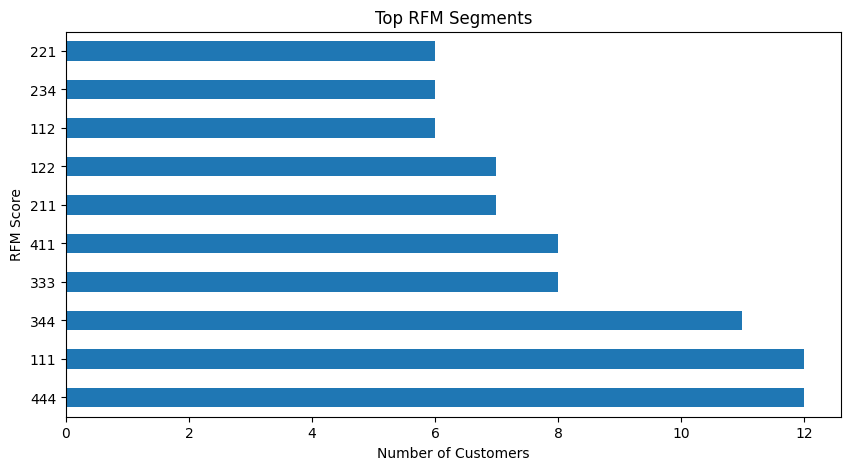

In [9]:

rfm['RFM_Score'].value_counts().head(10).plot(kind='barh', figsize=(10, 5))
plt.title("Top RFM Segments")
plt.xlabel("Number of Customers")
plt.ylabel("RFM Score")
plt.show()
    

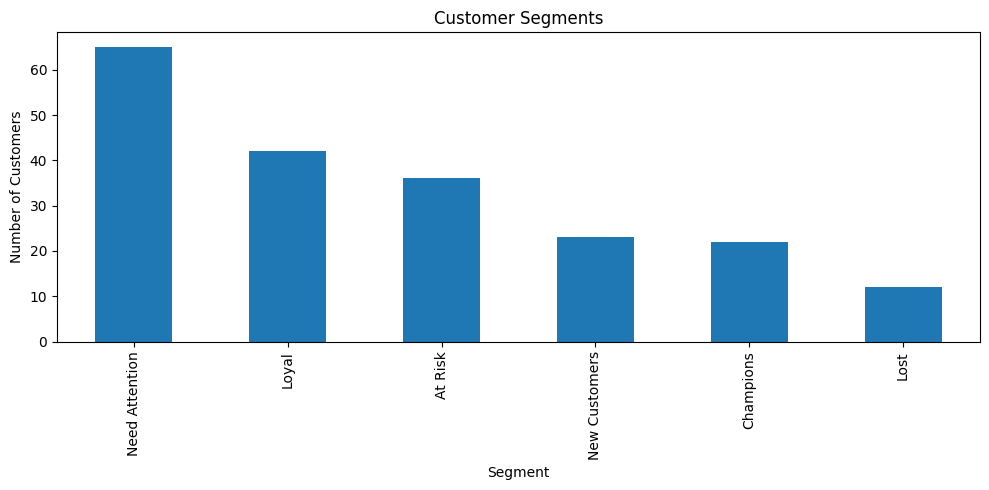

In [10]:
# Define a function to label segments
def segment_customer(row):
    r, f, m = int(row['R_quartile']), int(row['F_quartile']), int(row['M_quartile'])
    
    if r == 4 and f >= 3 and m >= 3:
        return "Champions"
    elif r >= 3 and f >= 3:
        return "Loyal"
    elif r == 4 and f <= 2:
        return "New Customers"
    elif r <= 2 and f >= 3:
        return "At Risk"
    elif r == 1 and f == 1 and m == 1:
        return "Lost"
    else:
        return "Need Attention"

# Apply the function
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# View segment distribution
rfm['Segment'].value_counts().plot(kind='bar', figsize=(10,5), title='Customer Segments')
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


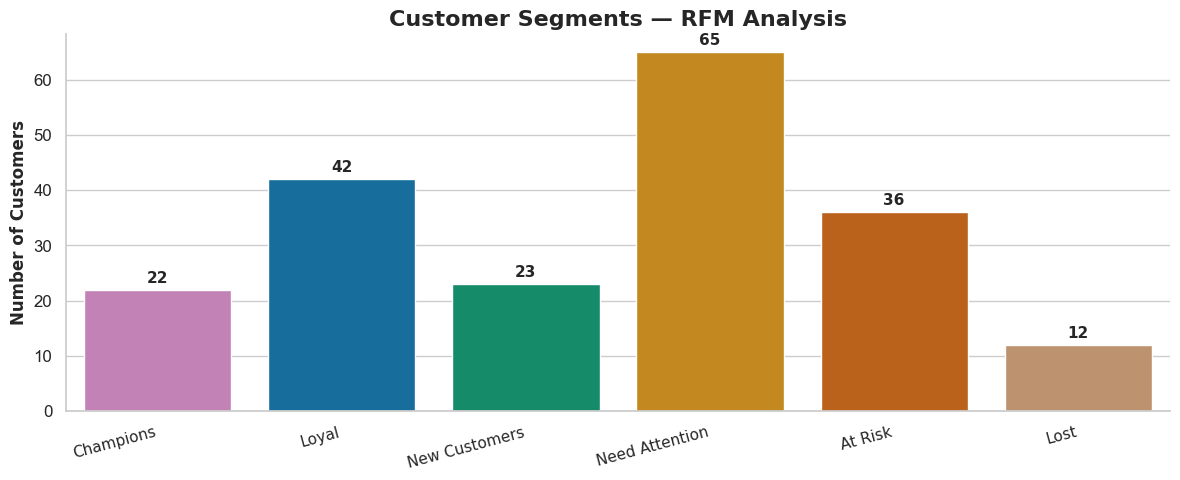

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'

sns.set_theme(style="whitegrid", font_scale=1.1)

segment_order = ["Champions", "Loyal", "New Customers", "Need Attention", "At Risk", "Lost"]

plt.figure(figsize=(12, 5))
ax = sns.countplot(
    data=rfm,
    x="Segment",
    hue="Segment",
    order=segment_order,
    palette='colorblind',
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3,
                 fontsize=11, fontweight='bold', fontfamily='DejaVu Sans')

plt.title("Customer Segments — RFM Analysis", fontsize=16, weight='bold', family='DejaVu Sans')
plt.xlabel("")
plt.ylabel("Number of Customers", fontsize=12, weight='bold', family='DejaVu Sans')
plt.xticks(rotation=15, ha="right", fontsize=11, family='DejaVu Sans')

sns.despine()
plt.tight_layout()

# Save as high-res PNG
plt.savefig("../assets/segment_distribution.png", dpi=300)

plt.show()